# MAIS202 Project
### Gargi Singh and Jehan Dastoor

![To make your day better :)](https://media.gettyimages.com/videos/close-up-baboon-making-noise-on-telephone-video-id712-17?s=640x640)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.preprocessing import image
from keras_preprocessing.image import ImageDataGenerator #check underscore or not
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import regularizers, optimizers
from keras.optimizers import Adam

The idea of the project is to categorize skin lesions based on the kind of cancer they are. The project will consist of a few major components:

1) Importing and pre-processing the images by transformation (to increase the size of the dataset).

2) Creating our model, i.e. deciding our layers that we are going to use (possibly based off an already built tensorflow model).

3) Training the model.

4) Testing the model using our test data set.

##1. Importing and pre-processing the data

In [ ]:
#Importing our data

#First, finding what the right diagnosis type would be for the different cancer types
traindfdiagnosis = pd.read_csv("/content/drive/MyDrive/MAIS/ISIC2018_Task3_Training_LesionGroupings.csv")
IMG_SIZE = 64

def append_ext(fn):
    return fn+".jpg"

traindfdiagnosis["image"]=traindfdiagnosis["image"].apply(append_ext)
datagen = ImageDataGenerator(rescale=1./255.,
                             validation_split=0.2, 
                             rotation_range=30,
                             width_shift_range=0.15,
                             height_shift_range=0.15,
                             shear_range=0.1,
                             zoom_range=0.2,
                             horizontal_flip=True)

datagen_valid = ImageDataGenerator(rescale=1./255.,
                             validation_split=0.2)

train_generator_diagnosis = datagen.flow_from_dataframe(dataframe=traindfdiagnosis,
                                              directory="/content/drive/MyDrive/MAIS/ISIC2018_Task3_Training_Input",
                                              x_col="image",
                                              y_col="diagnosis_confirm_type",
                                              subset="training",
                                              batch_size=32,
                                              color_mode="rgb",
                                              shuffle=False,
                                              class_mode="categorical",
                                              target_size=(IMG_SIZE,IMG_SIZE))

valid_generator_diagnosis = datagen_valid.flow_from_dataframe(dataframe=traindfdiagnosis,
                                              directory="/content/drive/MyDrive/MAIS/ISIC2018_Task3_Training_Input",
                                              x_col="image",
                                              y_col="diagnosis_confirm_type",
                                              subset="validation",
                                              batch_size=32,
                                              color_mode="rgb",
                                              shuffle=False,
                                              class_mode="categorical",
                                              target_size=(IMG_SIZE,IMG_SIZE))


Found 8012 validated image filenames belonging to 4 classes.
Found 2003 validated image filenames belonging to 4 classes.


In [ ]:
#Finding what the actual cancer type is from the categorical data
traindfcanc = pd.read_csv("/content/drive/MyDrive/MAIS/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv")
traindfcanc["image"]=traindfcanc["image"].apply(append_ext)

column_names = traindfcanc.columns.to_list()[1:]

datagen_canc = ImageDataGenerator(rescale=1./255.,
                             validation_split=0.2,
                             rotation_range=30,
                             width_shift_range=0.15,
                             height_shift_range=0.15,
                             #shear_range=0.1,
                             zoom_range=0.1,
                             horizontal_flip=True)

datagen_canc_valid = ImageDataGenerator(rescale=1./255.,
                             validation_split=0.2)

train_generator_canc = datagen_canc.flow_from_dataframe(dataframe=traindfcanc,
                                              directory="/content/drive/MyDrive/MAIS/ISIC2018_Task3_Training_Input",
                                              x_col="image",
                                              y_col=list(column_names),
                                              subset="training",
                                              batch_size=32,
                                              color_mode="rgb",
                                              shuffle=False,
                                              class_mode="raw",
                                              target_size=(IMG_SIZE,IMG_SIZE))

valid_generator_canc = datagen_canc_valid.flow_from_dataframe(dataframe=traindfcanc,
                                              directory="/content/drive/MyDrive/MAIS/ISIC2018_Task3_Training_Input",
                                              x_col="image",
                                              y_col=list(column_names),
                                              subset="validation",
                                              batch_size=32,
                                              color_mode="rgb",
                                              shuffle=False,
                                              class_mode="raw",
                                              target_size=(IMG_SIZE,IMG_SIZE))

Found 8012 validated image filenames.
Found 2003 validated image filenames.


##2.a) Creating the Model for Diagnosis Type

In [ ]:
#The pre-trained model we are going to use for both tasks is DenseNet201 

base_model = tf.keras.applications.ResNet50V2(input_shape=(IMG_SIZE,IMG_SIZE,3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False #so that we are not retraining the base

94674944/94668760 [==============================] - 3s 0us/step


In [ ]:
#Whether we want to use the pre-trained model or not
pre_trained = False

#Building the model
model = Sequential()
if pre_trained:
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5)) #to reduce overfitting
    model.add(BatchNormalization())
else:
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    model.add(Dropout(0.5)) #to reduce overfitting

model.add(Dense(4, activation='softmax'))

model.compile(optimizer=Adam(lr=1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 2304)            

##3.a) Training for Diagnosis Type

In [ ]:
#Running the Model
STEP_SIZE_TRAIN=train_generator_diagnosis.n//train_generator_diagnosis.batch_size
STEP_SIZE_VALID=valid_generator_diagnosis.n//valid_generator_diagnosis.batch_size

#Creating our checkpoints
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=3,
                                  verbose=1, factor=0.2, min_lr=1e-7)

filepath="diagnosis_model.h5"
checkpoint_diagnosis = ModelCheckpoint(filepath, monitor='val_accuracy', 
                                       verbose=1, save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor="val_accuracy", patience=4,
                               min_delta=0, verbose=1, mode="auto")

diagnosis = model.fit_generator(generator=train_generator_diagnosis,
                                steps_per_epoch=STEP_SIZE_TRAIN,
                                epochs=20,
                                validation_data=valid_generator_diagnosis,
                                validation_steps=STEP_SIZE_VALID,
                                callbacks=[learn_control, checkpoint_diagnosis, early_stopping],
                                verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
250/250 [==============================] - 99s 396ms/step - loss: 1.0101 - accuracy: 0.6263 - val_loss: 0.4853 - val_accuracy: 0.8669

Epoch 00001: val_accuracy improved from -inf to 0.86694, saving model to diagnosis_model.h5
Epoch 2/20
250/250 [==============================] - 98s 394ms/step - loss: 0.5560 - accuracy: 0.8403 - val_loss: 0.4620 - val_accuracy: 0.8725

Epoch 00002: val_accuracy improved from 0.86694 to 0.87248, saving model to diagnosis_model.h5
Epoch 3/20
250/250 [==============================] - 99s 396ms/step - loss: 0.4798 - accuracy: 0.8692 - val_loss: 0.4757 - val_accuracy: 0.8664

Epoch 00003: val_accuracy did not improve from 0.87248
Epoch 4/20
250/250 [==============================] - 98s 394ms/step - loss: 0.4867 - accuracy: 0.8624 - val_loss: 0.4209 - val_accuracy: 0.8861

Epoch 00004: val_accuracy improved from 0.87248 to 0.88609, saving model to diagnosis_model.h5
Epoch 5/20
250/250 [==============================] - 99s 396ms/step - loss: 0.

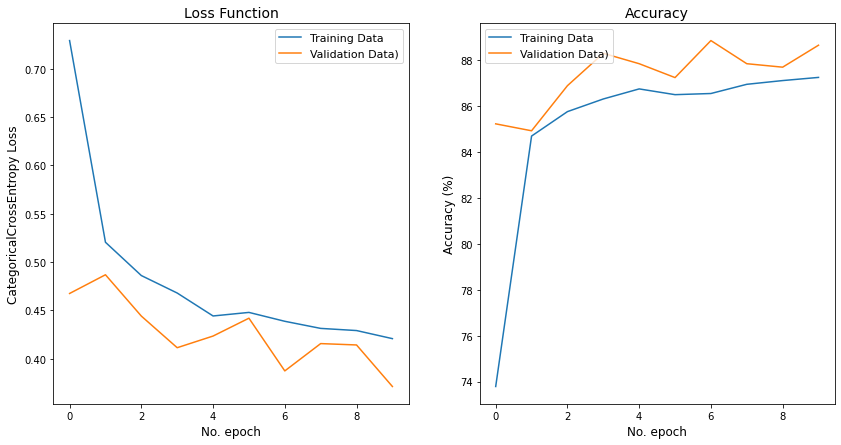

In [ ]:
#Creating plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))

ax1.plot(diagnosis.history['loss'], label='Training Data')
ax1.plot(diagnosis.history['val_loss'], label='Validation Data)')
ax1.set_title('Loss Function', fontsize=14)
ax1.set_ylabel('CategoricalCrossEntropy Loss', fontsize=12)
ax1.set_xlabel('No. epoch', fontsize=12)
ax1.legend(loc="upper right", fontsize=11)

ax2.plot([100*i for i in diagnosis.history['accuracy']], label='Training Data')
ax2.plot([100*i for i in diagnosis.history['val_accuracy']], label='Validation Data)')
ax2.set_title('Accuracy', fontsize=14)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_xlabel('No. epoch', fontsize=12)
ax2.legend(loc="upper left", fontsize=11)

#plt.savefig("Model_plots.png", bbox_inches="tight", dpi=200)
plt.show()

##2.b) Creating the Model for Cancer Type

In [ ]:
#Whether we want to use the pre-trained model or not
pre_trained = False

#Building the model
model_canc = Sequential()

if pre_trained:
    model_canc.add(base_model)
    model_canc.add(GlobalAveragePooling2D())
    model_canc.add(Dropout(0.5)) #to reduce overfitting
    model_canc.add(BatchNormalization())
else:
    model_canc.add(Conv2D(64, (3, 3), padding="same", activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model_canc.add(MaxPooling2D((2, 2)))

    model_canc.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
    model_canc.add(MaxPooling2D((2, 2)))

    model_canc.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
    model_canc.add(MaxPooling2D((2, 2)))

    #model_canc.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
    #model_canc.add(MaxPooling2D((2, 2)))

    model_canc.add(Flatten())
    model_canc.add(Dense(256, activation='relu'))
    model_canc.add(Dense(64, activation='relu'))

model_canc.add(Dense(7, activation='softmax'))

model_canc.compile(optimizer=Adam(lr=1e-4),
                   loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])
model_canc.build((None,IMG_SIZE, IMG_SIZE, 3))
model_canc.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 8192)             

##3.b) Training the Model for Cancer Type

In [ ]:
#Running the Model
STEP_SIZE_TRAIN_CANC=train_generator_canc.n//train_generator_canc.batch_size
STEP_SIZE_VALID_CANC=valid_generator_canc.n//valid_generator_canc.batch_size

filepath_cancer="cancer_model.h5"
checkpoint_cancer = ModelCheckpoint(filepath_cancer, monitor='val_accuracy', 
                                    verbose=1, save_best_only=True, mode='max')

learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=3,
                                  verbose=1, factor=0.2, min_lr=1e-7)

early_stopping = EarlyStopping(monitor="val_accuracy", patience=4,
                               min_delta=0, verbose=1, mode="auto")

cancer = model_canc.fit_generator(generator=train_generator_canc,
                                  steps_per_epoch=STEP_SIZE_TRAIN_CANC,
                                  epochs=50,
                                  validation_data=valid_generator_canc,
                                  validation_steps=STEP_SIZE_VALID_CANC,
                                  callbacks=[learn_control, checkpoint_cancer, early_stopping],
                                  verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
250/250 [==============================] - 101s 400ms/step - loss: 1.2187 - accuracy: 0.6354 - val_loss: 0.9639 - val_accuracy: 0.6855

Epoch 00001: val_accuracy improved from -inf to 0.68548, saving model to cancer_model.h5
Epoch 2/50
250/250 [==============================] - 100s 399ms/step - loss: 1.0261 - accuracy: 0.6590 - val_loss: 0.8763 - val_accuracy: 0.6855

Epoch 00002: val_accuracy did not improve from 0.68548
Epoch 3/50
250/250 [==============================] - 99s 396ms/step - loss: 0.9394 - accuracy: 0.6631 - val_loss: 0.8451 - val_accuracy: 0.6875

Epoch 00003: val_accuracy improved from 0.68548 to 0.68750, saving model to cancer_model.h5
Epoch 4/50
250/250 [==============================] - 99s 398ms/step - loss: 0.9045 - accuracy: 0.6696 - val_loss: 0.8085 - val_accuracy: 0.7051

Epoch 00004: val_accuracy improved from 0.68750 to 0.70514, saving model to cancer_model.h5
Epoch 5/50
250/250 [==============================] - 100s 400ms/step - loss: 0.8733 -

In [ ]:
#Evaluating our model
model_canc.evaluate_generator(train_generator_canc,verbose=1)

In [ ]:
#Training more from the saved model
from keras.models import load_model

canc_loaded = load_model("/content/cancer_model.h5")
cancer = canc_loaded.fit_generator(generator=train_generator_canc,
                                  steps_per_epoch=STEP_SIZE_TRAIN_CANC,
                                  epochs=30,
                                  validation_data=valid_generator_canc,
                                  validation_steps=STEP_SIZE_VALID_CANC,
                                  callbacks=[learn_control, checkpoint_cancer, early_stopping],
                                  verbose=1)

##4. Evaluating the Model

###Plotting the results of our cancer type training so we can visualise our progress better.

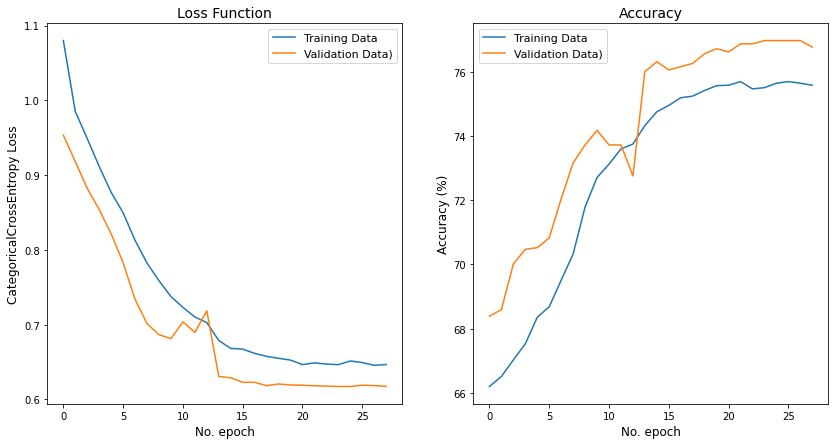

In [ ]:
#Creating plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))

ax1.plot(cancer.history['loss'], label='Training Data')
ax1.plot(cancer.history['val_loss'], label='Validation Data)')
ax1.set_title('Loss Function', fontsize=14)
ax1.set_ylabel('CategoricalCrossEntropy Loss', fontsize=12)
ax1.set_xlabel('No. epoch', fontsize=12)
ax1.legend(loc="upper right", fontsize=11)

ax2.plot([100*i for i in cancer.history['accuracy']], label='Training Data')
ax2.plot([100*i for i in cancer.history['val_accuracy']], label='Validation Data)')
ax2.set_title('Accuracy', fontsize=14)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_xlabel('No. epoch', fontsize=12)
ax2.legend(loc="upper left", fontsize=11)

plt.savefig("Model_plots.png", bbox_inches="tight", dpi=200)
plt.show()

In [ ]:
#Finding values for confusion matrix
import math
number_of_generator_calls = math.ceil(STEP_SIZE_VALID_CANC+1) 
# 1.0 above is to skip integer division

valid_labels = []

for i in range(0,int(number_of_generator_calls)):
    valid_labels.extend(np.array(valid_generator_canc[i][1]))

#Converting one-hot encoding to integers
y_true = [np.where(r==1)[0][0] for r in valid_labels]

In [ ]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

#Creating our confusion matrix
#Confution Matrix and Classification Report
Y_pred = model_canc.predict_generator(valid_generator_canc, STEP_SIZE_VALID_CANC+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
#print(confusion_matrix(y_true, y_pred))
conf = confusion_matrix(y_true,y_pred)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix


In [ ]:
import itertools
def confusion_matrix_plot(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig("Confusion_Matrix.png",bbox_inches="tight",dpi=200)
    plt.show()

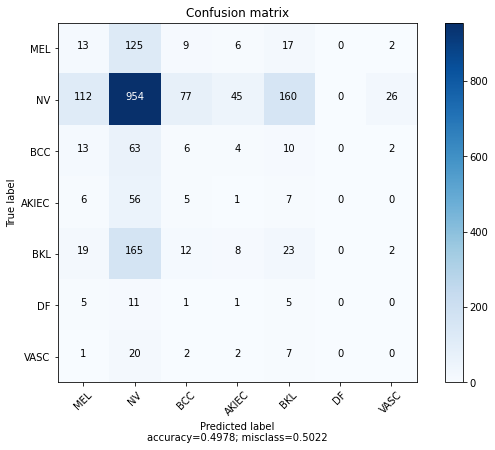

In [ ]:
#Plotting confusion matrix
confusion_matrix_plot(conf,target_names=column_names,normalize=False)

In [ ]:
while True:
    pass